In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random
import itertools



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p05" #
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p02" #

#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p01" #
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p1" # need smaller jitter
suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # !! Really nice. Same/better results with less PCs. 98% var.
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really v good, better than 35pca (best PC implementation)


In [3]:
dataset_bank_pca = pd.read_csv(f'../dataframes/{suffix}_dataset_bank_pca.csv', compression='gzip', index_col=0)
dataset_bank_test = pd.read_csv(f'../dataframes/{suffix}_dataset_bank_pca_test.csv', compression='gzip', index_col=0)
dataset_bank_orig = pd.read_pickle('../dataframes/dataset_label_orig_SMOTE_train_test_80-20_addJiterNorm0p02.pkl')

full_ann_properties_df = pd.read_csv(f'../dataframes/full_ann_properties_df_{suffix}.csv', index_col=0)


In [4]:
dataset_bank_test['tns_cls'] = full_ann_properties_df['ann=0_tns_cls']

dataset_bank_pca['tns_cls'] = dataset_bank_orig
dataset_bank_pca

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,tns_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF19ackimld,0.858025,0.339311,-0.105688,3.093747,2.077710,-0.443271,0.344216,-0.299946,-0.925827,0.021907,...,0.340006,-0.034759,-0.285459,0.321981,-0.022686,0.169241,-0.229535,-0.177052,0.250099,None
ZTF20acoxdas,-0.740785,-0.283205,-0.167640,-0.220809,-0.832822,0.190447,-0.120570,0.310394,-0.146085,-0.330513,...,0.065204,-0.041055,0.096941,-0.086817,-0.095633,-0.032070,-0.014252,-0.059623,-0.000100,SN Ia
ZTF20acibvgy,2.137347,-1.344610,-0.517321,0.095846,0.267009,0.104581,0.143262,0.927478,-0.393607,-0.150505,...,-0.024979,0.086803,0.171737,0.037491,0.194006,0.031685,0.207480,0.087662,0.261283,None
ZTF20acbrlih,-0.587440,-1.821763,0.032487,0.647071,0.182052,-1.112913,0.848824,-0.728806,-0.563102,0.278786,...,0.098265,0.009517,0.157943,-0.182629,-0.134519,-0.182856,0.008537,-0.262579,-0.130953,None
ZTF19aadfqfw,0.498874,-0.302524,-1.664336,-1.063328,-0.228154,0.840535,0.668896,0.686625,-0.483497,-0.669830,...,0.093595,-0.374658,-0.040281,-0.312642,-0.196905,0.301349,-0.004140,0.299036,0.026054,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFabc04253,1.324453,0.212717,-0.994195,1.545677,0.504468,-0.384897,-0.126507,0.054607,0.116719,0.176251,...,-0.031406,0.074687,0.124908,-0.168912,-0.058870,0.013253,-0.028939,0.015859,0.018143,TDE
ZTFabc63992,-1.015652,1.949318,0.341864,1.913586,0.527218,-0.393197,0.232048,0.339729,-0.114695,0.324182,...,-0.189212,-0.053491,-0.051868,-0.128460,-0.052201,0.019851,0.101670,-0.145061,-0.029818,TDE
ZTFabc31499,-1.368472,1.567038,0.680710,0.445702,-0.609586,-0.064284,0.218972,0.332787,-0.379442,-0.383723,...,-0.112888,-0.093015,0.035321,0.080565,0.118897,0.047852,0.081132,0.022404,0.003025,TDE


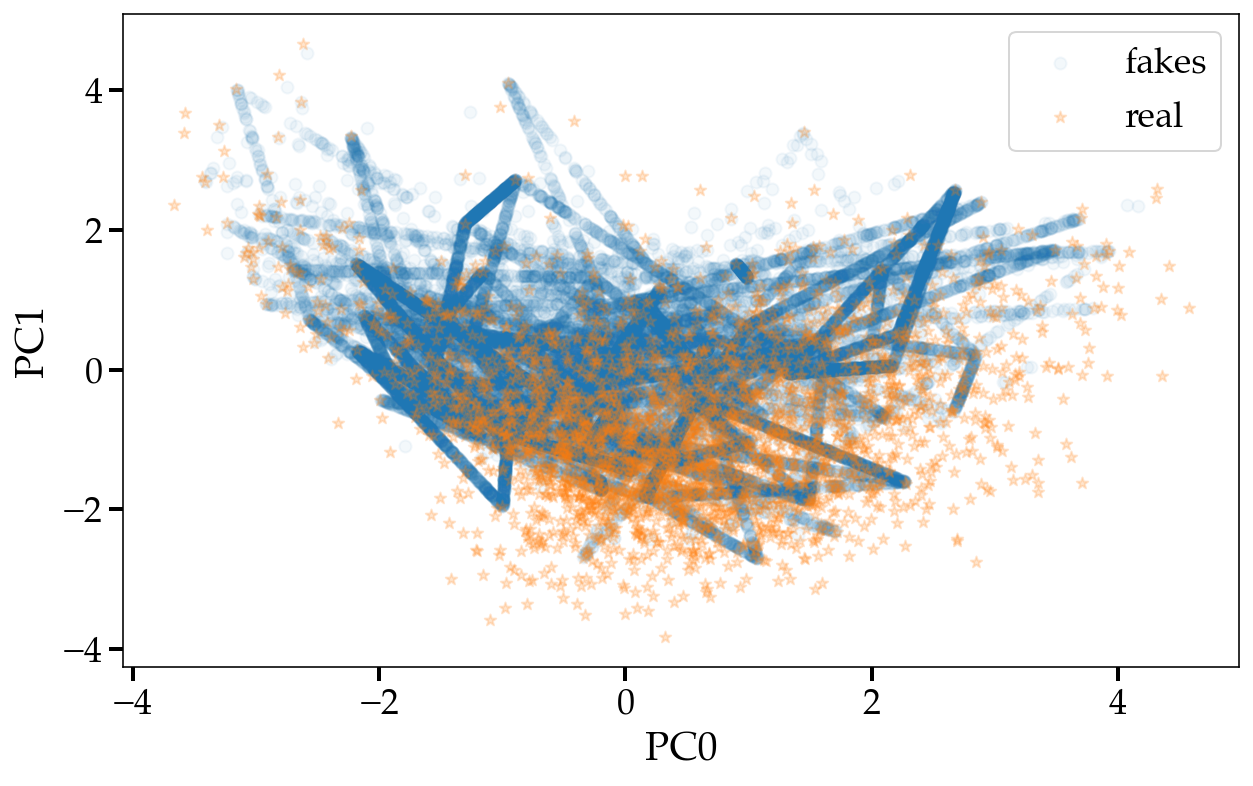

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_pca[dataset_bank_pca.index.str.startswith('ZTFabc')]

ax.scatter(fakes_df['PC0'], fakes_df['PC1'], alpha=0.05, marker='o', label='fakes')
ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend()
plt.show()

In [6]:
marker = itertools.cycle(('.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd')) 

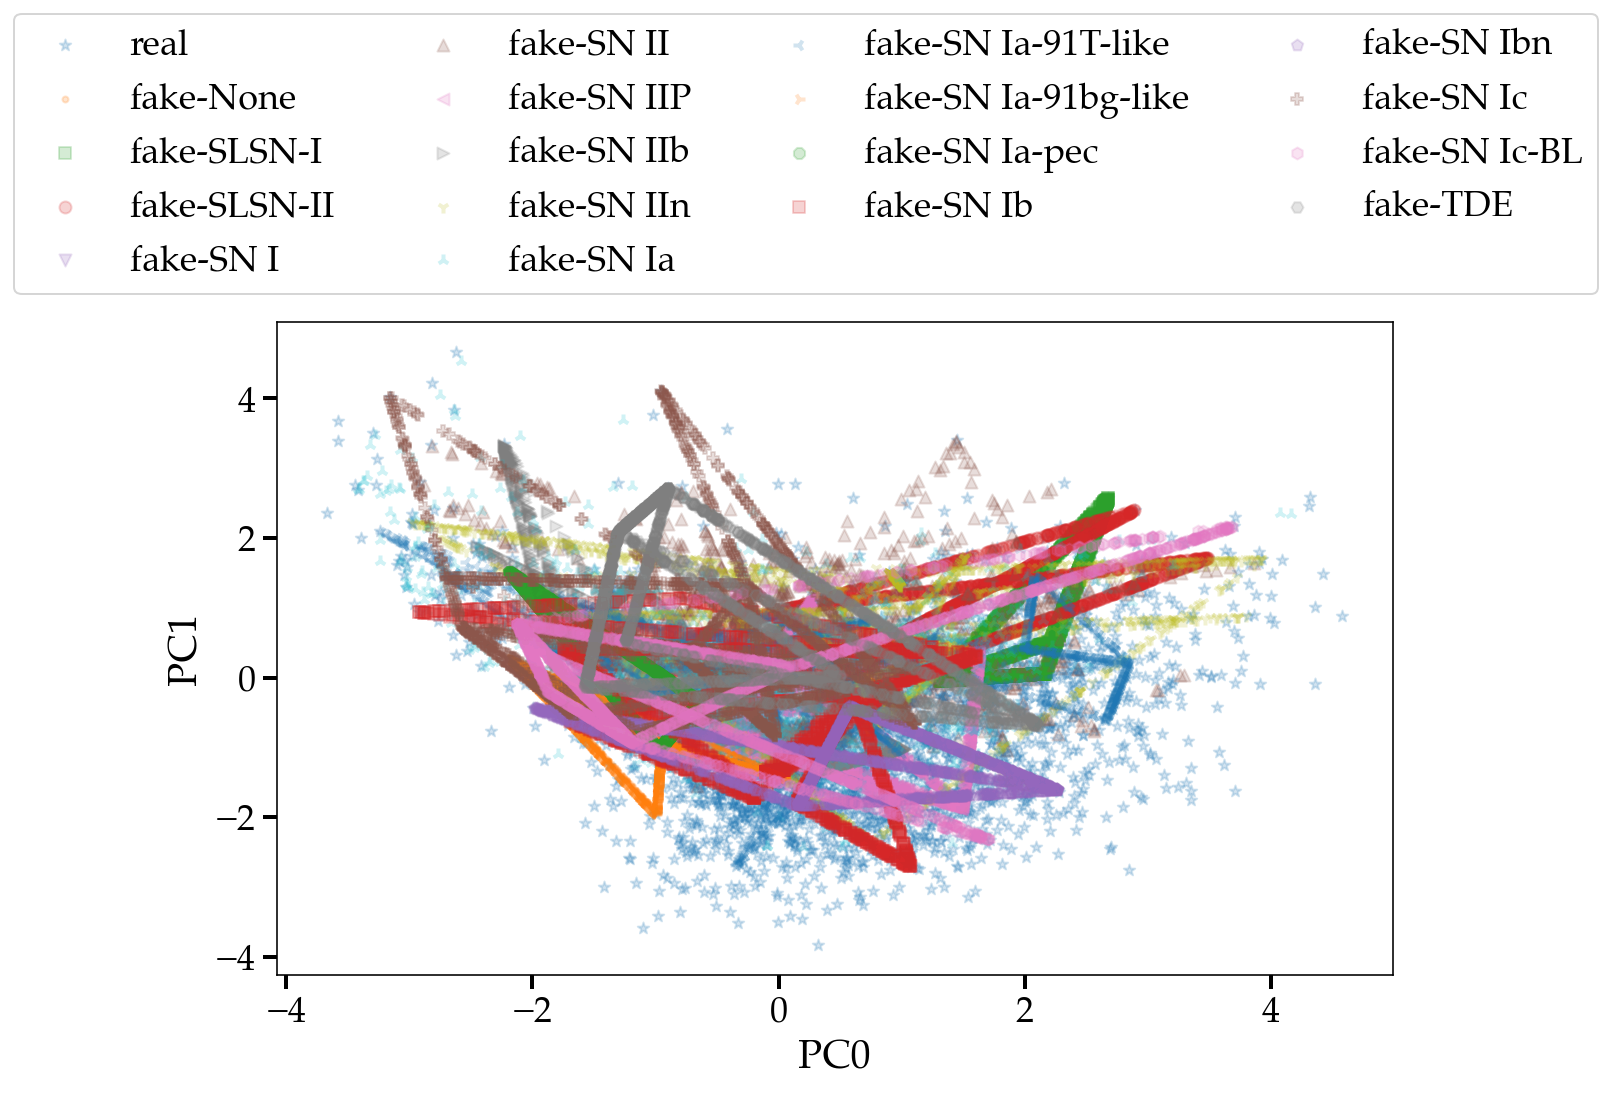

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_pca[dataset_bank_pca.index.str.startswith('ZTFabc')]

ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')

marker_l = ['.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|'] 
for marker, cls in zip(marker_l, np.unique(dataset_bank_pca.tns_cls)):
    fakes_cls_df = fakes_df[fakes_df.tns_cls == cls]
    ax.scatter(fakes_cls_df['PC0'], fakes_cls_df['PC1'], alpha=0.2, marker=marker, label=f'fake-{cls}')

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.5))

folder_path = f"../figures/principal_components/{suffix}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/principal_components/{suffix}/fakes_cls_df.jpg', dpi=250, bbox_inches='tight')
plt.show()

In [8]:
# not upsampling None (no fakes), and few Ia fakes, so fakes doesn't cover all regions
# But fakes does cover outlier regions
# streaks are from extreme upsampling of O(few) instances of minority classes with 2knn

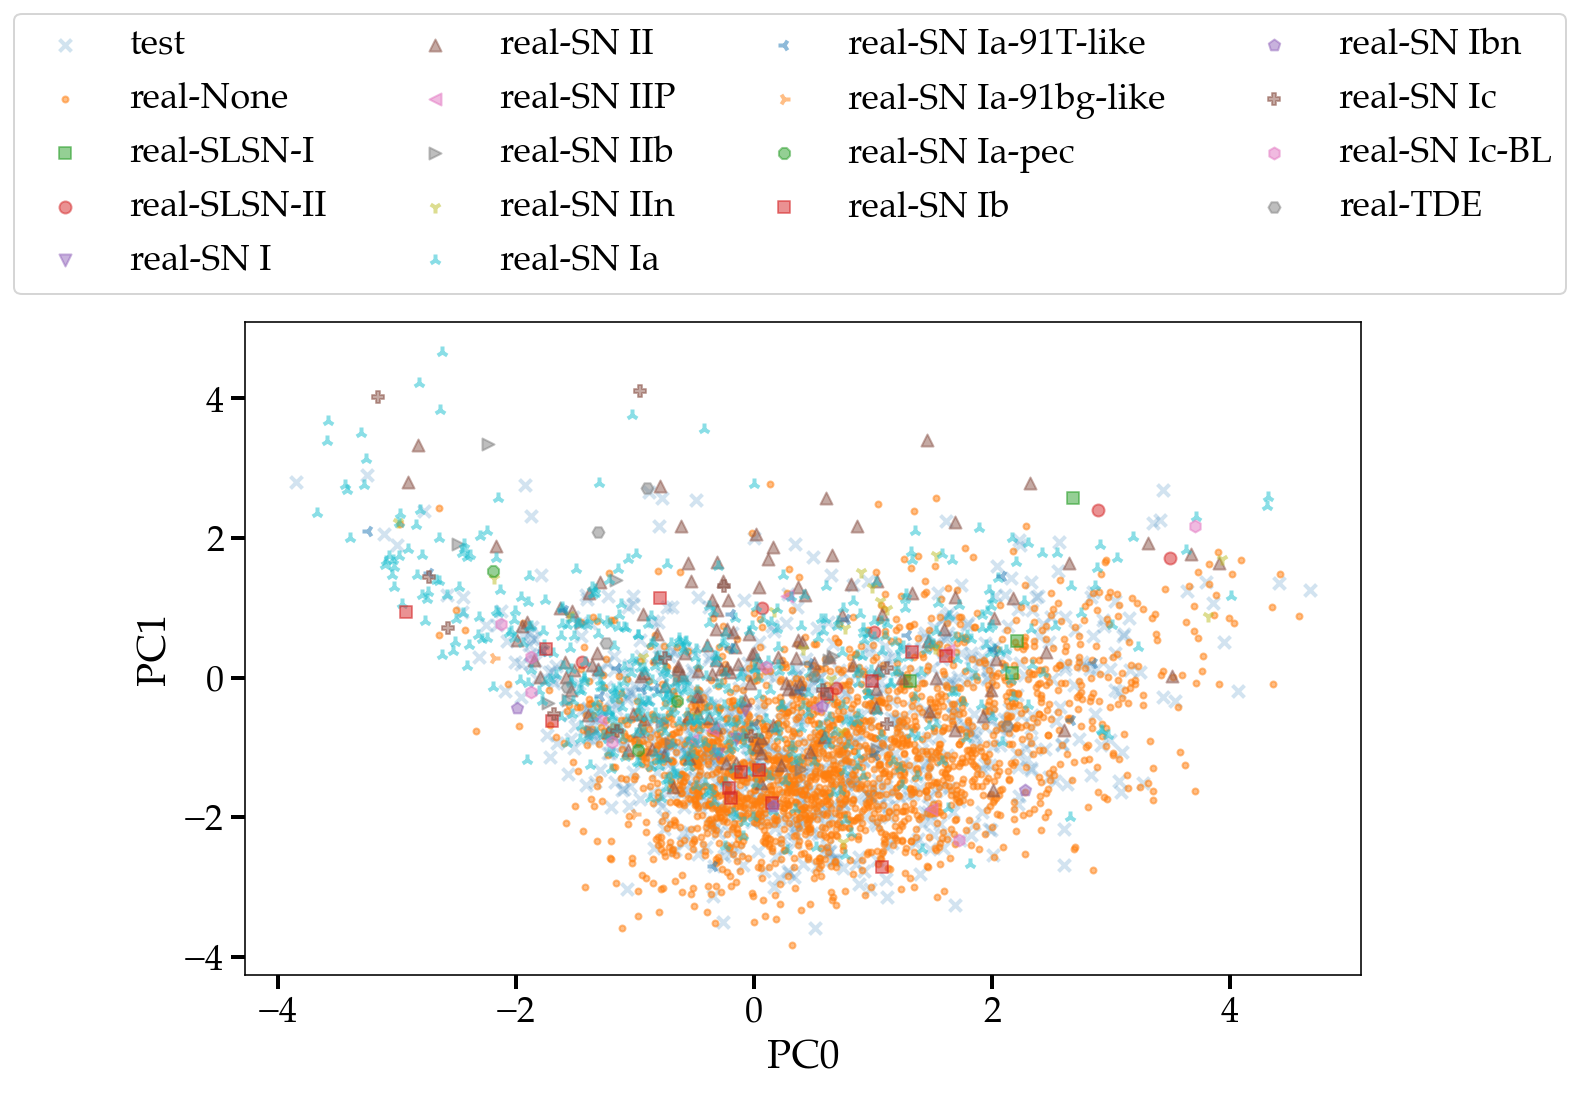

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
test_df = dataset_bank_test

ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.2, marker='x',label='test')


marker_l = ['.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|'] 
for marker, cls in zip(marker_l, np.unique(dataset_bank_pca.tns_cls)):
    real_cls_df = real_df[real_df.tns_cls == cls]
    ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], alpha=0.5, marker=marker, label=f'real-{cls}')

#ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')
#ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.05, marker='x',label='test')

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.5))
plt.savefig(f'../figures/principal_components/{suffix}/real_cls_df.jpg', dpi=250, bbox_inches='tight')
plt.show()

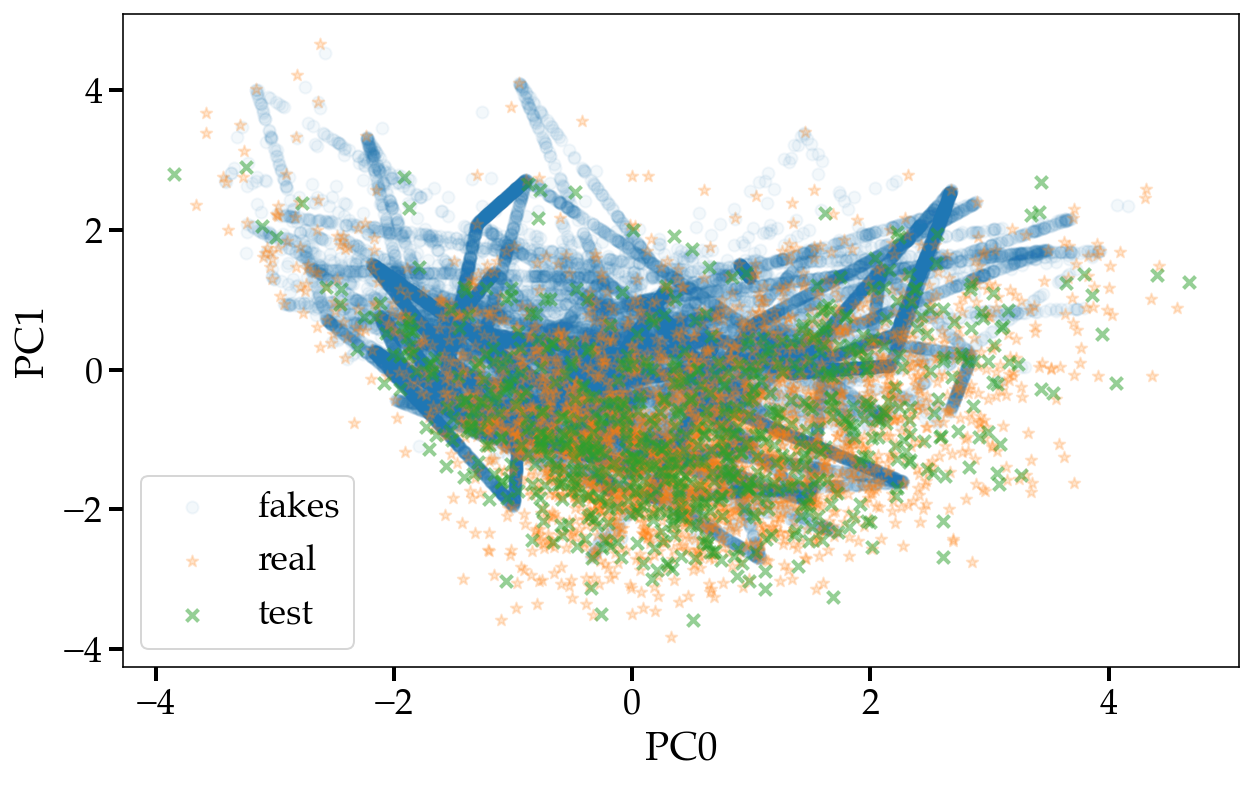

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_pca[dataset_bank_pca.index.str.startswith('ZTFabc')]
test_df = dataset_bank_test

ax.scatter(fakes_df['PC0'], fakes_df['PC1'], alpha=0.05, marker='o', label='fakes')
ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')
ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.5, marker='x',label='test')

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend()
plt.savefig(f'../figures/principal_components/{suffix}/real_vs_fakes_vs_test.jpg', dpi=250, bbox_inches='tight')
plt.show()

In [11]:
cut_df = test_df[(test_df['PC1'] < -3)]
cut_df

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,tns_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aaksawu,-0.262140,-3.504466,0.616816,1.209718,0.661164,-0.257705,-0.523244,-0.575221,0.904068,0.364453,...,0.066471,0.017333,0.392063,-0.179097,0.127767,0.006438,0.232378,0.179787,-0.018337,None
ZTF21abiawat,-0.346834,-3.123215,0.151231,1.428379,-0.511257,-1.538351,0.400685,-1.108380,-0.210977,0.656972,...,0.134779,0.009740,0.071178,-0.100794,-0.373514,-0.136294,0.255559,0.248141,-0.141872,None
ZTF21abpjsrn,1.115267,-3.137602,1.274888,0.484063,-0.668682,-0.399371,-0.929180,0.207503,0.007515,0.958908,...,0.176202,0.041881,0.082381,-0.006090,-0.113031,-0.047707,0.328068,0.226566,-0.093954,None
ZTF21aahjzav,1.686299,-3.261495,-1.156696,1.185954,0.138083,0.206756,0.098396,0.085249,-0.281192,-0.544261,...,0.230908,-0.233861,0.052074,-0.364071,-0.195871,-0.034056,0.111526,0.233502,-0.018870,None
ZTF20acwogqz,0.514054,-3.584500,0.184830,1.135993,0.661093,0.115661,-0.262611,-0.467678,0.137673,0.161747,...,0.134107,0.129695,0.177798,-0.298983,-0.125912,-0.173136,0.213419,0.020373,-0.112755,SN Ia
ZTF19aaafmjk,0.977863,-3.034247,0.669502,0.714455,0.860751,0.163847,-0.075963,0.012125,1.345386,0.919353,...,-0.138391,0.107214,0.178428,0.090971,-0.060719,-0.256779,0.003424,0.156299,-0.233498,None
ZTF19aadftkd,-1.064629,-3.023617,-0.010979,0.172885,-0.577362,-1.116748,-0.785445,-0.701149,-0.503592,-0.068917,...,0.124084,0.050857,0.050719,0.128511,-0.328268,0.121759,0.192858,0.059132,0.061942,None


In [12]:
for sn, cl in zip(cut_df.index, cut_df.tns_cls):
    print(f'https://alerce.online/object/{sn}', cl)

https://alerce.online/object/ZTF21aaksawu None
https://alerce.online/object/ZTF21abiawat None
https://alerce.online/object/ZTF21abpjsrn None
https://alerce.online/object/ZTF21aahjzav None
https://alerce.online/object/ZTF20acwogqz SN Ia
https://alerce.online/object/ZTF19aaafmjk None
https://alerce.online/object/ZTF19aadftkd None


In [13]:
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20"

In [14]:
# train/test before smote has same embedding mostly
# smote covers regions it's supposed to

In [15]:
test_df[(test_df['PC0'] > 20) & (test_df['PC1'] < -20)]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,tns_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,


In [10]:
# https://alerce.online/object/ZTF18abdhozj - remaining periodic var
# https://alerce.online/object/ZTF20acqucpz - remaining CV

In [12]:
real_df[(real_df['PC0'] < -20) & (real_df['PC1'] > 15)]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21abdtkdc,-22.163253,22.511544,-7.627958,-2.259726,-3.433426,-2.808574,-4.373169,0.230342,6.517101,-1.174292,...,1.207785,-0.965603,2.253548,1.345902,-2.990527,-1.364164,-2.640205,0.319725,-1.411165,-0.142190
ZTF21aarvysz,-20.838052,19.716343,-11.223825,-9.730916,-4.214124,-2.776630,-2.469222,4.432431,3.459800,-0.015755,...,-0.822607,0.529747,2.099676,0.324822,-0.193822,-0.413322,-3.663055,1.086797,-0.874276,-0.521186
ZTF21aardzlu,-20.609653,17.887838,-1.452162,-1.571780,5.446219,-0.511114,-2.816245,-0.564413,3.411933,1.063307,...,0.949911,-0.015324,-1.113844,-0.854960,0.542895,-1.589053,-0.632498,0.795945,-1.980645,-0.460658


In [ ]:
# all 3 are flat LCs with None tns spec class

In [14]:
test_df[(test_df['PC0'] < 10) & (test_df['PC1'] > 20)]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF18abwxrhi,4.527623,21.511848,18.555454,11.050699,4.83806,-4.791629,21.238319,19.539585,-4.750731,-5.895489,...,-2.344125,-2.972335,3.366347,-0.763277,-1.839438,-1.142456,3.152264,1.380873,2.985124,3.431534


In [ ]:
# https://alerce.online/object/ZTF18abwxrhi
# that weird maybe double peak SN / bogus second bump obs

In [16]:
test_df[(test_df['PC0'] < -25) & (test_df['PC1'] < -10)]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF18aaqdlle,-29.344679,-11.608744,10.294377,-2.510227,26.038514,2.667018,0.422067,5.172922,3.517185,-0.851667,...,-2.391525,-1.821549,-0.830398,-0.426677,0.503373,0.106479,-1.140716,0.549167,-2.004430,1.444579
ZTF18acclacc,-29.015988,-16.451279,5.987124,1.856043,21.864505,-1.625007,3.249946,9.712309,5.493366,2.360775,...,-2.382828,0.074992,0.530949,-1.617456,-0.956524,-2.599603,-0.943605,0.078554,-2.304119,0.805382


In [ ]:
# SN in template images

In [17]:
test_df[(test_df['PC0'] < -20) & (test_df['PC1'] < -10)]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aasttsm,-20.298472,-11.896813,11.995602,-11.060080,1.215294,-1.563570,-3.610145,-6.124563,1.568291,3.397161,...,2.120320,1.851662,0.597470,0.474003,-1.956241,0.637700,1.965622,3.005612,-1.149632,-0.702561
ZTF21abrduyv,-24.222897,-14.482757,9.234705,3.250013,3.324799,1.948191,-2.928338,0.997722,-3.465844,0.748486,...,1.806170,0.148293,-2.418226,1.868700,-3.024807,0.368600,0.244908,-0.247381,0.245462,1.318686
ZTF21aaqhxvc,-22.256702,-14.075184,3.824647,7.586351,3.233600,-0.435544,1.882573,-0.221733,2.065071,-0.445902,...,-0.848070,0.833937,-3.098243,-0.176281,0.424199,0.163895,1.152259,-1.147861,-0.593108,1.061885
ZTF18aaqdlle,-29.344679,-11.608744,10.294377,-2.510227,26.038514,2.667018,0.422067,5.172922,3.517185,-0.851667,...,-2.391525,-1.821549,-0.830398,-0.426677,0.503373,0.106479,-1.140716,0.549167,-2.004430,1.444579
ZTF18acclacc,-29.015988,-16.451279,5.987124,1.856043,21.864505,-1.625007,3.249946,9.712309,5.493366,2.360775,...,-2.382828,0.074992,0.530949,-1.617456,-0.956524,-2.599603,-0.943605,0.078554,-2.304119,0.805382
ZTF21abcwnub,-20.716612,-10.193120,2.729436,-3.701176,0.192830,-1.169605,-1.817422,1.924119,-2.593268,-0.191790,...,0.801612,-0.347447,-1.637663,0.352083,-1.687103,-0.606164,1.077189,-0.676988,0.659723,-1.162769


In [ ]:
# ALL ZTF21 LCs are rising and top out before 2nd peak, tightly sampled Ia in small elliptical galaxies

# 2 PCs (43% of variance) do pretty good job.